In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


from astropy.io import fits
import dill as pickle
from emcee import EnsembleSampler
import numpy as np
import os
import sys

pwd = os.getcwd()
little_things_root_dir = os.path.dirname(pwd)
sys.path.append(little_things_root_dir)

from little_things_lib.galaxy import Galaxy
from little_things_lib.nfw_mcmc_fitter import (
    EmceeParameters,
    get_mcmc_start_position, 
    generate_nwalkers_start_points, 
    lnprob)
from little_things_lib.plotting import plot_posterior_distributions, plot_walker_paths

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

## Enter parameters for galaxy in cell below

In [2]:
galaxy_name = 'UGC3974'

X_DIM, Y_DIM = 1024,1024
DEG_PER_PIXEL = 4.17e-4
DISTANCE = 8000 # kpc

# can leave these as any number for now, not used
LUMINOSITY = 1e8  # solar luminositiy
HI_MASS = 1e8  # solar masses

In [3]:
mcmc_params = EmceeParameters(
    ndim=3,
    nwalkers=10, 
    nburn=50,
    niter=200,
    nthin=0,
    nthreads=4
)

In [4]:
"""
Expect the data to be provided in following naming convention in 'data' directory:

2D observed velocity field FITS file: <galaxy_name>_1mom.fits
Bbarolo fit parameters text file: <galaxy_name>_ring_parameters.txt
Stellar velocity curve: <galaxy_name>_stellar_velocities.txt
Gas velocity_curve: <galaxy_name>_gas_velocities.txt

"""


data_dir = os.path.join(little_things_root_dir, 'data')

observed_2d_vel_field_fits_file = os.path.join(data_dir, f'{galaxy_name}_1mom.fits')
ring_parameters_file = os.path.join(data_dir, f'{galaxy_name}_ring_parameters.txt')

stellar_velocities_file = os.path.join(data_dir, f'{galaxy_name}_stellar_velocities.txt')
gas_velocities_file = os.path.join(data_dir, f'{galaxy_name}_gas_velocities.txt')


In [5]:
radii_kpc, test_rotation_curve, inclinations, position_angles, x_centers, y_centers , v_systemics = \
    np.loadtxt(ring_parameters_file, usecols=(0,2,4,5,-4,-3,-2)).T

avg_inclination = np.mean(inclinations)
avg_position_angle = np.mean(position_angles)
avg_x_center = np.mean(x_centers)
avg_y_center = np.mean(y_centers)
v_systemic = np.mean(v_systemics)

observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data

#stellar_radii, stellar_vel = np.loadtxt(stellar_velocities_file, unpack=True)
#gas_radii, gas_vel = np.loadtxt(gas_velocities_file, unpack=True)

In [6]:
stellar_radii = np.linspace(0, 4500, 41)
gas_radii = np.linspace(0, 4500, 41)
stellar_vel = np.linspace(0, 1, 41)
gas_vel = np.linspace(0, 1, 41)

In [7]:
galaxy = Galaxy(
    distance_to_galaxy=DISTANCE,  # [kpc] Look this up for the galaxy 
    deg_per_pixel=DEG_PER_PIXEL ,  # 'CRDELT1' and 'CRDELT2' in the FITS file header (use absolute value)
    image_xdim=X_DIM,
    image_ydim=Y_DIM,
    galaxy_name=galaxy_name,
    vlos_2d_data=observed_2d_vel_field,
    output_dir='output',
    luminosity=LUMINOSITY,
    HI_mass=HI_MASS)

tilted_ring_params = {
    'v_systemic': v_systemic,
    'radii': radii_kpc,   
    'inclination': inclinations,
    'position_angle': position_angles,
    'x_pix_center': x_centers,
    'y_pix_center': y_centers
}

galaxy.set_tilted_ring_parameters(**tilted_ring_params)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='stellar',
    rotation_curve_radii=stellar_radii,
    rotation_curve_velocities=stellar_vel)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='gas',
    rotation_curve_radii=gas_radii,
    rotation_curve_velocities=gas_vel)

# initialize MCMC start position and bounds
galaxy.set_nfw_prior_bounds(
    rhos_bounds=(1e6, 1e9),   # msun / kpc^3
    rs_bounds=(0.1, 10),  # kpc
    ml_bounds=(0.1, 10),
  
)

In [8]:
# This will print warnings if the start points go outside prior bounds

start_point, start_point_radii = get_mcmc_start_position(galaxy)
start_pos = generate_nwalkers_start_points(galaxy, mcmc_params.nwalkers, start_point, start_point_radii)

In [9]:
sampler = EnsembleSampler(
    mcmc_params.nwalkers,
    mcmc_params.ndim, 
    lnprob, 
    args=[galaxy], 
    threads=mcmc_params.nthreads)

# this will break up the fitting procedure into smaller chunks of size batch_size and save progress

batch_size = 20
mcmc_output = []
for batch in range(mcmc_params.niter // batch_size):
    if batch== 0:
        batch_start = start_pos 
    else:
        batch_start = None
        sampler.pool = temp_pool
    mcmc_output += sampler.run_mcmc(batch_start, batch_size)
    temp_pool = sampler.pool
    del sampler.pool
    with open('sampler.pkl', 'wb') as f:
        pickle.dump(sampler, f)
    with open('mcmc_output.pkl', 'wb') as f:
        pickle.dump(mcmc_output, f)
    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_params.n_iter}")


(array([[ 6.45320202,  0.19304379,  5.18721246],
        [ 6.94167814,  0.60315314,  3.37124118],
        [ 6.84690557,  0.94317116,  3.7227461 ],
        [ 7.04728862, -0.01661656,  4.22025618],
        [ 8.22483732, -0.27947361,  8.90988316],
        [ 8.25393206,  0.95508377,  2.22820273],
        [ 6.45836426,  0.51269173,  0.74788664],
        [ 8.15895921, -0.65808247,  2.87371639],
        [ 6.99582033,  0.96718949,  6.09216378],
        [ 6.28534868,  0.40237799,  1.87400348]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 ('MT19937', array([1171765679, 4243865477, 3239838694, 2465110749, 1427990250,
          625982755, 2677626290, 2685309826, 2478212478, 4273209944,
         4069466087,  942810063,  689106171, 1917046693, 3069787354,
         2007693470, 3639493692,  727978673, 1619222429, 1138228055,
         1031850101, 2815443506, 4289925782, 3036186775, 2123444885,
         4036108279, 1102533230, 1841858053, 3871821927, 2569035920,
         2991301791, 1909663318, 

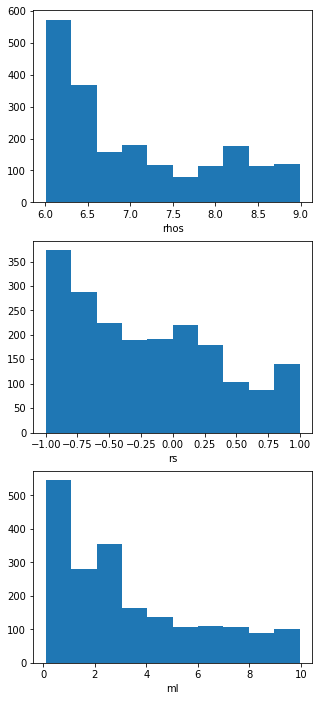

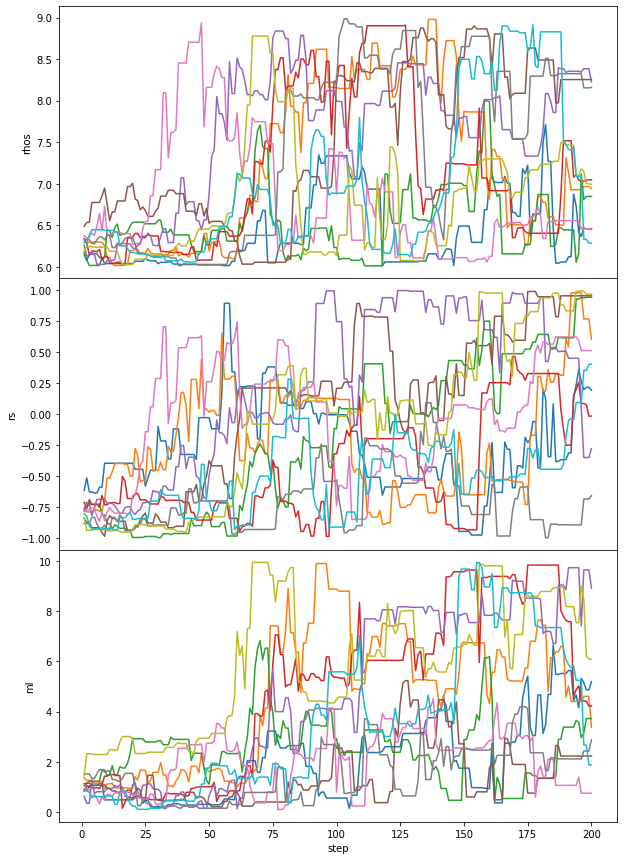

In [10]:
plot_posterior_distributions(sampler, labels=['rhos', 'rs', 'ml'])

plot_walker_paths(
    sampler,
    mcmc_params,
    labels=['rhos', 'rs', 'ml'])


#### Compare observed 2d velocity field with one generated during fitting process

In [ ]:
example_2d_field = mcmc_output[-1][2][-1]
plt.imshow(example_2d_field)
plt.imshow(galaxy.vlos_2d_data)